# Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [30]:
df1 = pd.read_csv("/content/drive/MyDrive/Dataset/DS310_TH2/ner_dataset.csv", encoding="latin1")

In [2]:
df_train = pd.read_json("/content/drive/MyDrive/Dataset/DS310_TH2/word/train_word.json", lines=True)
df_test = pd.read_json("/content/drive/MyDrive/Dataset/DS310_TH2/word/test_word.json", lines=True)
df_dev = pd.read_json("/content/drive/MyDrive/Dataset/DS310_TH2/word/dev_word.json", lines=True)

df2 = pd.concat([df_train, df_test, df_dev], axis = 0).reset_index(drop=True)

# Hàm

In [3]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

Hàm preprocess để tiền xử lý dữ liệu, trích xuất ra:
* words_function: list các từ vựng của bộ dữ liệu
* num_words_function: số lượng từ trong bộ từ vựng words
* tags_function: list các tag của bộ dữ liệu
* n_tags_function: số lượng tag trong tags
* sentence_function: bộ câu kèm tag của câu đó
* word2idx_function: từ điển để ánh xạ từ sang index
* tag2idx_function: từ điển để ánh xạ tag sang index
<br>
<br>
Với đầu vào là:
* df: dataframe
* type: (1,2) Loại tiền xử lí cho dữ liệu câu 1 hoặc câu 2

In [26]:
def preprocess(df, type):
  if(type == 1):
      
    df = df.drop(['POS'], axis =1)
    df = df.fillna(method="ffill")

    words_function = set(list(df['Word'].values))
    words_function.add('PADword')
    n_words_function = len(words_function)

    tags_function = list(set(df["Tag"].values))
    n_tags_function = len(tags)

    getter = SentenceGetter(df)
    sent = getter.get_next()

    sentences_function = getter.sentences

    words2index_function = {w:i for i,w in enumerate(words_function)}
    tags2index_function = {t:i for i,t in enumerate(tags_function)}
    idx2tag_function = {i: w for w, i in tags2index_function.items()}

  if(type == 2):
    words_function = []
    for i in range(len(df)):
      words_function += df["words"][i]

    words_function = list(set(words_function))
    words_function.append("PADword")
    n_words_function = len(words_function)

    tags_function = []
    for i in range(len(df)):
      tags_function += df["tags"][i]

    tags_function = list(set(tags_function))
    n_tags_function = len(tags_function)

    sentences_function = [df.loc[i] for i in range(len(df))]

    words2index_function = {w: i   for i, w in enumerate(words_function)}
    tags2index_function = {t: i for i, t in enumerate(tags_function)}
    idx2tag_function = {i: w for w, i in tags2index_function.items()}

  return words_function, n_words_function, tags_function, n_tags_function, sentences_function, words2index_function, tags2index_function, idx2tag_function

Hàm token_padding để tokenize các câu và tag thành index; padding câu và tag.  <br>
  **Với đầu vào:**
* padding: độ dài tối đa của câu
* sentence: bộ câu kèm tag của câu đó
* word2idx: từ điển ánh xạ từ sang index
* tag2idx: từ điển ánh xạ tag sang index
* num_words: số lượng từ trong từ điển 
* type: (1,2) Loại xử lí cho câu 1 hoặc câu 2
<br><br>
  **Đầu ra:**
* X: input sequence đã được padding
* y: output sequence đã được padding

In [47]:
def token_padding(padding, sentences, word2idx, tag2idx, num_words, type):
  #ánh xạ từ trong câu và nhãn về index của nó
  from tensorflow.keras.preprocessing.sequence import pad_sequences
  #đặt max length cho phù hợp
  max_len = padding

  if(type == 1):
    X = [[w[0]for w in s] for s in sentences]
    new_X = []
    for seq in X:
        new_seq = []
        for i in range(max_len):
            try:
                new_seq.append(seq[i])
            except:
                new_seq.append("PADword")
        new_X.append(new_seq)

    y = [[tag2idx[w[1]] for w in s] for s in sentences]
    y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])
  
  if(type == 2):
    X = [[w for w in s[0]] for s in sentences]
    new_X = []
    for seq in X:
        new_seq = []
        for i in range(max_len):
            try:
                new_seq.append(seq[i])
            except:
                new_seq.append("PADword")
        new_X.append(new_seq)

    y = [[tag2idx[w] for w in s[1]] for s in sentences]
    y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

  return new_X, y

Hàm pred2label và test2label lần lượt dùng để chuyển index trong sequence thành tag để tiện hơn trong việc quan sát và đánh giá

In [6]:
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PADword", "O"))
        out.append(out_i)
    return out

def test2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            out_i.append(idx2tag[int(p)].replace("PADword", "O"))
        out.append(out_i)
    return out

# Câu 1

## Tiền xử lí

---



In [18]:
words, num_words, tags, n_tags, sentences, word2idx, tag2idx, idx2tag = preprocess(df1, 1)

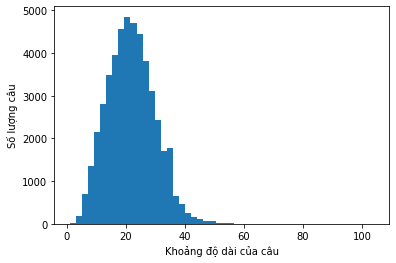

In [9]:
%matplotlib inline
plt.hist([len(sen) for sen in sentences], bins= 50)
plt.xlabel("Khoảng độ dài của câu")
plt.ylabel("Số lượng câu")
plt.show()

In [33]:
max_len = 50
X, y = token_padding(max_len, sentences, word2idx, tag2idx, num_words, 1)

In [43]:
from sklearn.model_selection import train_test_split
batch_size = 32

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=2018)

train_number_batches = len(X_train)//batch_size

X_train, X_val = X_train[:train_number_batches*batch_size], X_train[-135*batch_size:]
y_train, y_val = y_train[:train_number_batches*batch_size], y_train[-135*batch_size:]
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], 1)
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)

## Model

### Function và Pre-trained model

In [22]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import tensorflow_hub as hub
from tensorflow.compat.v1.keras import backend as K
sess = tf.Session()
K.set_session(sess)

ELMo cho Extracting Features từ Text

In [23]:
elmo_model = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

Hàm để embedding input, là Lambda layer trong model chính

In [24]:
def ElmoEmbedding(x):
    return elmo_model(inputs={
                            "tokens": tf.squeeze(tf.cast(x, tf.string)),
                            "sequence_len": tf.constant(batch_size*[max_len])
                      },
                      signature="tokens",
                      as_dict=True)["elmo"]

Output là 1 tensor 3 chiều có shape là (x, y, z): <br>

* Chiều đầu tiên của tensor thể hiện cho số lượng sample trong dataset
* Chiều thứ 2 thể hiện cho chiều dài lớn nhất của string dài nhất trong input.
* Chiều thứ 3 là độ dài của vector ELMo <br>
Có nghĩa là mỗi từ trong câu sẽ được embedding thành 1 vector dài 1024

In [25]:
from keras.models import Model 
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda, add, Input
from keras.utils.vis_utils import plot_model

### Xây dựng model

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


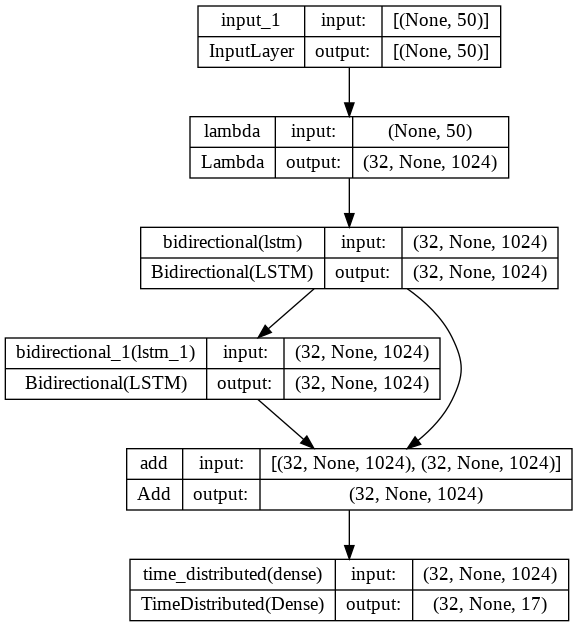

In [26]:
input_text = Input(shape=(max_len,), dtype=tf.string)
embedding = Lambda(ElmoEmbedding, output_shape=(max_len, 1024))(input_text)
x = Bidirectional(LSTM(units=512, return_sequences=True,
                       recurrent_dropout=0.2, dropout=0.2))(embedding)
x_rnn = Bidirectional(LSTM(units=512, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2))(x)
x = add([x, x_rnn])  # residual connection to the first biLSTM
out = TimeDistributed(Dense(n_tags, activation="softmax"))(x)

model = Model(input_text, out)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Train model

In [36]:
history = model.fit(np.array(X_train), y_train, validation_data=(np.array(X_val), y_val), batch_size=batch_size, epochs=1, verbose=1)

Train on 43136 samples, validate on 4320 samples
43136/43136 [==============================] - ETA: 0s - loss: 0.0612 - acc: 0.9821

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


43136/43136 [==============================] - 657s 15ms/sample - loss: 0.0612 - acc: 0.9821 - val_loss: 0.0422 - val_acc: 0.9864


### Lưu và load model

Save

In [68]:
# import pickle
# pickle.dump(model, open('/content/drive/MyDrive/Dataset/DS310_TH2/model_cau1_bai3.pkl', 'wb'))
model.save('/content/drive/MyDrive/Dataset/DS310_TH2/model_cau1_bai3.h5')
model.save_weights("/content/drive/MyDrive/Dataset/DS310_TH2/weight_cau1_bai3.h5")

Load

In [ ]:
import keras
pickled_model = pickle.load(open('/content/drive/MyDrive/Dataset/DS310_TH2/model_cau1_bai3.pkl', 'rb'))
loaded_model = keras.models.load_model('/content/drive/MyDrive/Dataset/DS310_TH2/model_cau1_bai3.h5') 

### Dự đoán

In [40]:
test_number_batches = len(X_test)//batch_size

X_test = X_test[:test_number_batches*batch_size]
test_pred = model.predict(np.array(X_test), verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Chuyển index sang label

In [58]:
pred_labels = pred2label(test_pred)
test_labels = test2label(y_test[:test_number_batches*batch_size])

## Đánh giá

In [61]:
from IPython.display import clear_output

sorted_tags = sorted(tags,key=lambda name: (name[1:], name[0]))
cfs_matrix = np.zeros((len(sorted_tags), len(sorted_tags)))
from sklearn.metrics import confusion_matrix

test_len = len(test_labels)

for i in range(len(test_labels)):
  print((i/test_len)*100,"%")
  clear_output(wait=True)
  cfs_matrix = np.add(confusion_matrix(np.array(test_labels)[i], np.array(pred_labels)[i], labels = sorted_tags), cfs_matrix)

99.97902684563759 %


In [62]:
import math
cols_cfs_matrix = cfs_matrix.T
sum_cfs_matrix = np.sum(cfs_matrix)
f1_scores = 0

for i in range(len(sorted_tags)):
  true_positive = cfs_matrix[i][i]
  false_positive = np.sum(cols_cfs_matrix[i]) - true_positive
  false_negative = np.sum(cfs_matrix[i]) - true_positive
  true_negative = sum_cfs_matrix - true_positive - false_negative - false_positive
  precision = true_positive / (true_positive + false_positive)
  recall = true_positive / (true_positive + false_negative)  
  f1 = 2 * (precision * recall) / (precision + recall)
  if(math.isnan(f1)):
    f1 = 0
  f1_scores += f1
  print(sorted_tags[i])
  print("     True Positive = {}, False Positive = {} , True Negative = {}, False Negative = {}".format(true_positive, false_positive, true_negative, false_negative))
  print("     Precision: {}, Recall: {}, F1-score: {}".format(precision, recall, f1))
  print("")
print("F1-macro: {}".format(f1_scores / len(sorted_tags)))

O
     True Positive = 221185.0, False Positive = 697.0 , True Negative = 15629.0, False Negative = 889.0
     Precision: 0.9968586906553935, Recall: 0.9959968298855336, F1-score: 0.9964275739037202

B-art
     True Positive = 7.0, False Positive = 10.0 , True Negative = 238341.0, False Negative = 42.0
     Precision: 0.4117647058823529, Recall: 0.14285714285714285, F1-score: 0.21212121212121207

I-art
     True Positive = 0.0, False Positive = 1.0 , True Negative = 238357.0, False Negative = 42.0
     Precision: 0.0, Recall: 0.0, F1-score: 0

B-eve
     True Positive = 12.0, False Positive = 14.0 , True Negative = 238353.0, False Negative = 21.0
     Precision: 0.46153846153846156, Recall: 0.36363636363636365, F1-score: 0.4067796610169492

I-eve
     True Positive = 9.0, False Positive = 15.0 , True Negative = 238352.0, False Negative = 24.0
     Precision: 0.375, Recall: 0.2727272727272727, F1-score: 0.3157894736842105

B-geo
     True Positive = 3350.0, False Positive = 626.0 , True

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


# Câu 2

## Tiền xử lí

---



In [48]:
words, num_words, tags, n_tags, sentences, word2idx, tag2idx, idx2tag = preprocess(df2, 2)

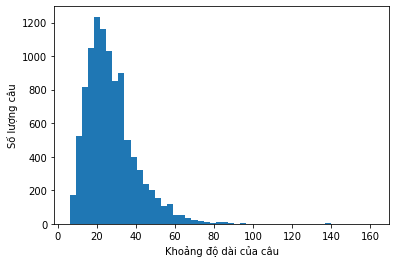

In [52]:
%matplotlib inline
plt.hist([len(sen[0]) for sen in sentences], bins= 50)
plt.xlabel("Khoảng độ dài của câu")
plt.ylabel("Số lượng câu")
plt.show()

In [49]:
max_len = 90
X, y = token_padding(max_len, sentences, word2idx, tag2idx, num_words, 2)

In [53]:
from sklearn.model_selection import train_test_split
batch_size = 32

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=2018)

train_number_batches = len(X_train)//batch_size

X_train, X_val = X_train[:train_number_batches*batch_size], X_train[-135*batch_size:]
y_train, y_val = y_train[:train_number_batches*batch_size], y_train[-135*batch_size:]
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], 1)
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)

## Model

### Function và Pre-trained model

In [54]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import tensorflow_hub as hub
from tensorflow.compat.v1.keras import backend as K
sess = tf.Session()
K.set_session(sess)

Instructions for updating:
non-resource variables are not supported in the long term


ELMo cho Extracting Features từ Text

In [55]:
elmo_model = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

Hàm để embedding input, là Lambda layer trong model chính

In [56]:
def ElmoEmbedding(x):
    return elmo_model(inputs={
                            "tokens": tf.squeeze(tf.cast(x, tf.string)),
                            "sequence_len": tf.constant(batch_size*[max_len])
                      },
                      signature="tokens",
                      as_dict=True)["elmo"]

Output là 1 tensor 3 chiều có shape là (x, y, z): <br>

* Chiều đầu tiên của tensor thể hiện cho số lượng sample trong dataset
* Chiều thứ 2 thể hiện cho chiều dài lớn nhất của string dài nhất trong input.
* Chiều thứ 3 là độ dài của vector ELMo <br>
Có nghĩa là mỗi từ trong câu sẽ được embedding thành 1 vector dài 1024

In [57]:
from keras.models import Model 
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda, add, Input
from keras.utils.vis_utils import plot_model

### Xây dựng model

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


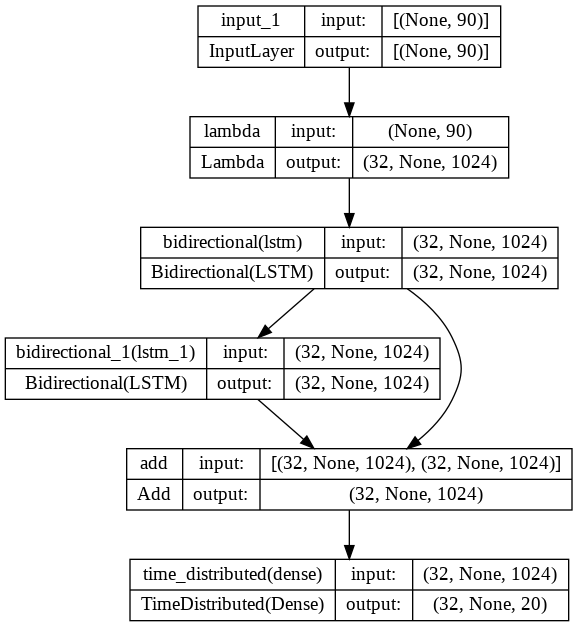

In [58]:
input_text = Input(shape=(max_len,), dtype=tf.string)
embedding = Lambda(ElmoEmbedding, output_shape=(max_len, 1024))(input_text)
x = Bidirectional(LSTM(units=512, return_sequences=True,
                       recurrent_dropout=0.2, dropout=0.2))(embedding)
x_rnn = Bidirectional(LSTM(units=512, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2))(x)
x = add([x, x_rnn])  # residual connection to the first biLSTM
out = TimeDistributed(Dense(n_tags, activation="softmax"))(x)

model = Model(input_text, out)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Train model

In [59]:
history = model.fit(np.array(X_train), y_train, validation_data=(np.array(X_val), y_val), batch_size=batch_size, epochs=2, verbose=1)

Train on 9024 samples, validate on 4320 samples
Epoch 1/2
9024/9024 [==============================] - ETA: 0s - loss: 0.1569 - acc: 0.9589

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


9024/9024 [==============================] - 301s 33ms/sample - loss: 0.1569 - acc: 0.9589 - val_loss: 0.0683 - val_acc: 0.9804
Epoch 2/2
9024/9024 [==============================] - 293s 32ms/sample - loss: 0.0616 - acc: 0.9823 - val_loss: 0.0465 - val_acc: 0.9864


### Lưu và load model

Save

In [60]:
# import pickle
# pickle.dump(model, open('/content/drive/MyDrive/Dataset/DS310_TH2/model_cau1_bai3.pkl', 'wb'))
model.save('/content/drive/MyDrive/Dataset/DS310_TH2/model_cau2_bai3.h5')
model.save_weights("/content/drive/MyDrive/Dataset/DS310_TH2/weight_cau2_bai3.h5")

Load

In [ ]:
import keras
# pickled_model = pickle.load(open('/content/drive/MyDrive/Dataset/DS310_TH2/model_cau1_bai3.pkl', 'rb'))
loaded_model = keras.models.load_model('/content/drive/MyDrive/Dataset/DS310_TH2/model_cau2_bai3.h5') 

### Dự đoán

In [61]:
test_number_batches = len(X_test)//batch_size

X_test = X_test[:test_number_batches*batch_size]
test_pred = model.predict(np.array(X_test), verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Chuyển index sang label

In [62]:
pred_labels = pred2label(test_pred)
test_labels = test2label(y_test[:test_number_batches*batch_size])

## Đánh giá

In [63]:
from IPython.display import clear_output

sorted_tags = sorted(tags,key=lambda name: (name[1:], name[0]))
cfs_matrix = np.zeros((len(sorted_tags), len(sorted_tags)))
from sklearn.metrics import confusion_matrix

test_len = len(test_labels)

for i in range(len(test_labels)):
  print((i/test_len)*100,"%")
  clear_output(wait=True)
  cfs_matrix = np.add(confusion_matrix(np.array(test_labels)[i], np.array(pred_labels)[i], labels = sorted_tags), cfs_matrix)

99.8991935483871 %


In [64]:
import math
cols_cfs_matrix = cfs_matrix.T
sum_cfs_matrix = np.sum(cfs_matrix)
f1_scores = 0

for i in range(len(sorted_tags)):
  true_positive = cfs_matrix[i][i]
  false_positive = np.sum(cols_cfs_matrix[i]) - true_positive
  false_negative = np.sum(cfs_matrix[i]) - true_positive
  true_negative = sum_cfs_matrix - true_positive - false_negative - false_positive
  precision = true_positive / (true_positive + false_positive)
  recall = true_positive / (true_positive + false_negative)  
  f1 = 2 * (precision * recall) / (precision + recall)
  if(math.isnan(f1)):
    f1 = 0
  f1_scores += f1
  print(sorted_tags[i])
  print("     True Positive = {}, False Positive = {} , True Negative = {}, False Negative = {}".format(true_positive, false_positive, true_negative, false_negative))
  print("     Precision: {}, Recall: {}, F1-score: {}".format(precision, recall, f1))
  print("")
print("F1-macro: {}".format(f1_scores / len(sorted_tags)))

O
     True Positive = 82570.0, False Positive = 623.0 , True Negative = 5641.0, False Negative = 446.0
     Precision: 0.9925113891793781, Recall: 0.9946275416787126, F1-score: 0.9935683386579548

B-AGE
     True Positive = 136.0, False Positive = 19.0 , True Negative = 89108.0, False Negative = 17.0
     Precision: 0.8774193548387097, Recall: 0.8888888888888888, F1-score: 0.8831168831168831

I-AGE
     True Positive = 0.0, False Positive = 0.0 , True Negative = 89280.0, False Negative = 0.0
     Precision: nan, Recall: nan, F1-score: 0

B-DATE
     True Positive = 528.0, False Positive = 27.0 , True Negative = 88721.0, False Negative = 4.0
     Precision: 0.9513513513513514, Recall: 0.9924812030075187, F1-score: 0.9714811407543699

I-DATE
     True Positive = 487.0, False Positive = 28.0 , True Negative = 88763.0, False Negative = 2.0
     Precision: 0.945631067961165, Recall: 0.9959100204498977, F1-score: 0.9701195219123505

B-GENDER
     True Positive = 106.0, False Positive = 16.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
